# Google Colab Object Detection Training and Inference for Stop Sign Detection with AI Images Added

### This notebook is run on Colab to avoid issues with GPU training on Windows

--From Roboflow (left this note for future troubleshooting): Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Nov 21 01:11:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Import OS and get the current working directory

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOV11 with ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/235.7 GB disk)


## Inference with model pre-trained on COCO dataset

Import libraries and use the yolo11n.pt as the main model to perform transfer learning from

In [ ]:
from IPython.display import Image as IPyImage
from ultralytics import YOLO
from PIL import Image
import requests
import supervision as sv

model = YOLO('yolo11n.pt')

100%|██████████| 5.35M/5.35M [00:00<00:00, 211MB/s]


## Tune YOLO11 model on our custom dataset

Create the datasets folder and move to that directory, then use roboflow to download the image dataset with training and testing folders

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow
from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="")
project = rf.workspace("screws-nvbc9").project("stopsignfinder_withai")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to StopSignFinder_withAI-1 in yolov11:: 100%|██████████| 488/488 [00:00<00:00, 8000.45it/s]


## Custom Training

Train the model. Task=detect is for a detection model, and model=yolo11s.pt uses transfer learning, we point towards the dataset location just created and labels .yaml, we also used 50 epochs and the real size of the image (512x512). This will be used for AI image model, and non AI image model

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=50 imgsz=512 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 399MB/s]
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/StopSignFinder_withAI-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

Training results are saved in `{HOME}/runs/detect/train/` - below lists the training output files for evaluation

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					   P_curve.png	     train_batch2.jpg
confusion_matrix_normalized.png			   PR_curve.png      train_batch320.jpg
confusion_matrix.png				   R_curve.png	     train_batch321.jpg
events.out.tfevents.1732151527.1ef9d956ed4e.977.0  results.csv	     train_batch322.jpg
F1_curve.png					   results.png	     val_batch0_labels.jpg
labels_correlogram.jpg				   train_batch0.jpg  val_batch0_pred.jpg
labels.jpg					   train_batch1.jpg  weights


Let's look at the confusion matrix

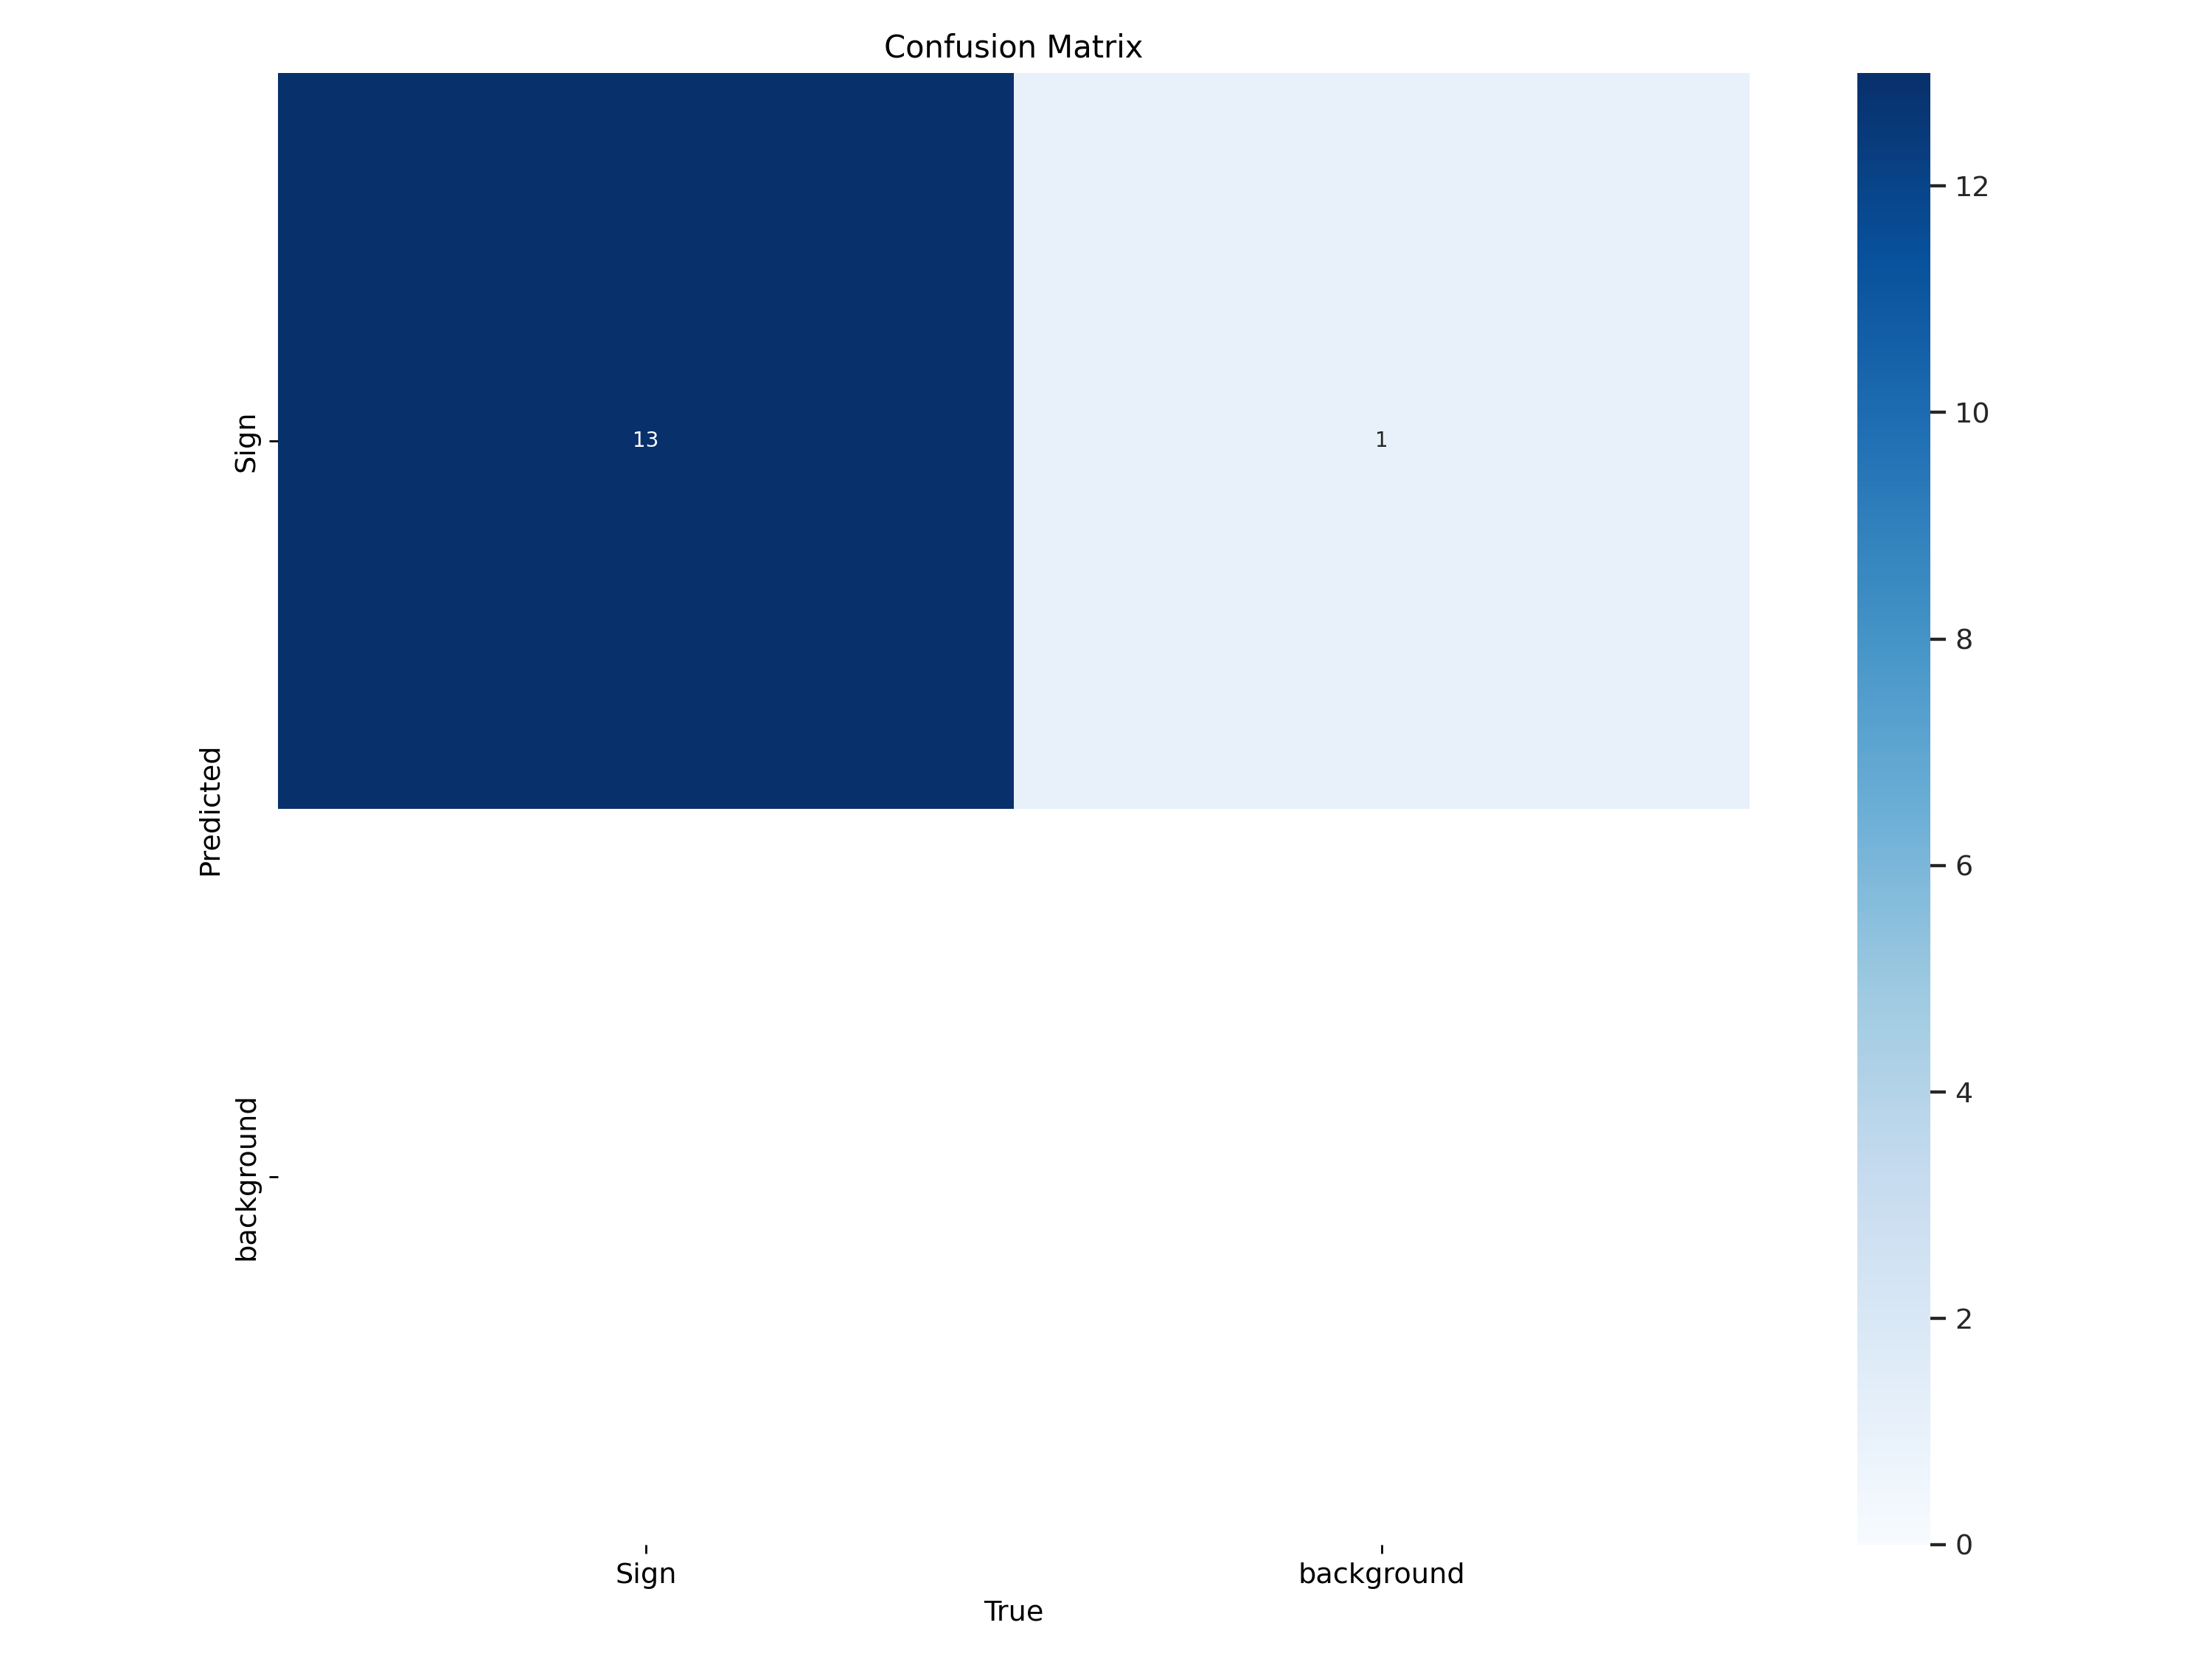

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1200)

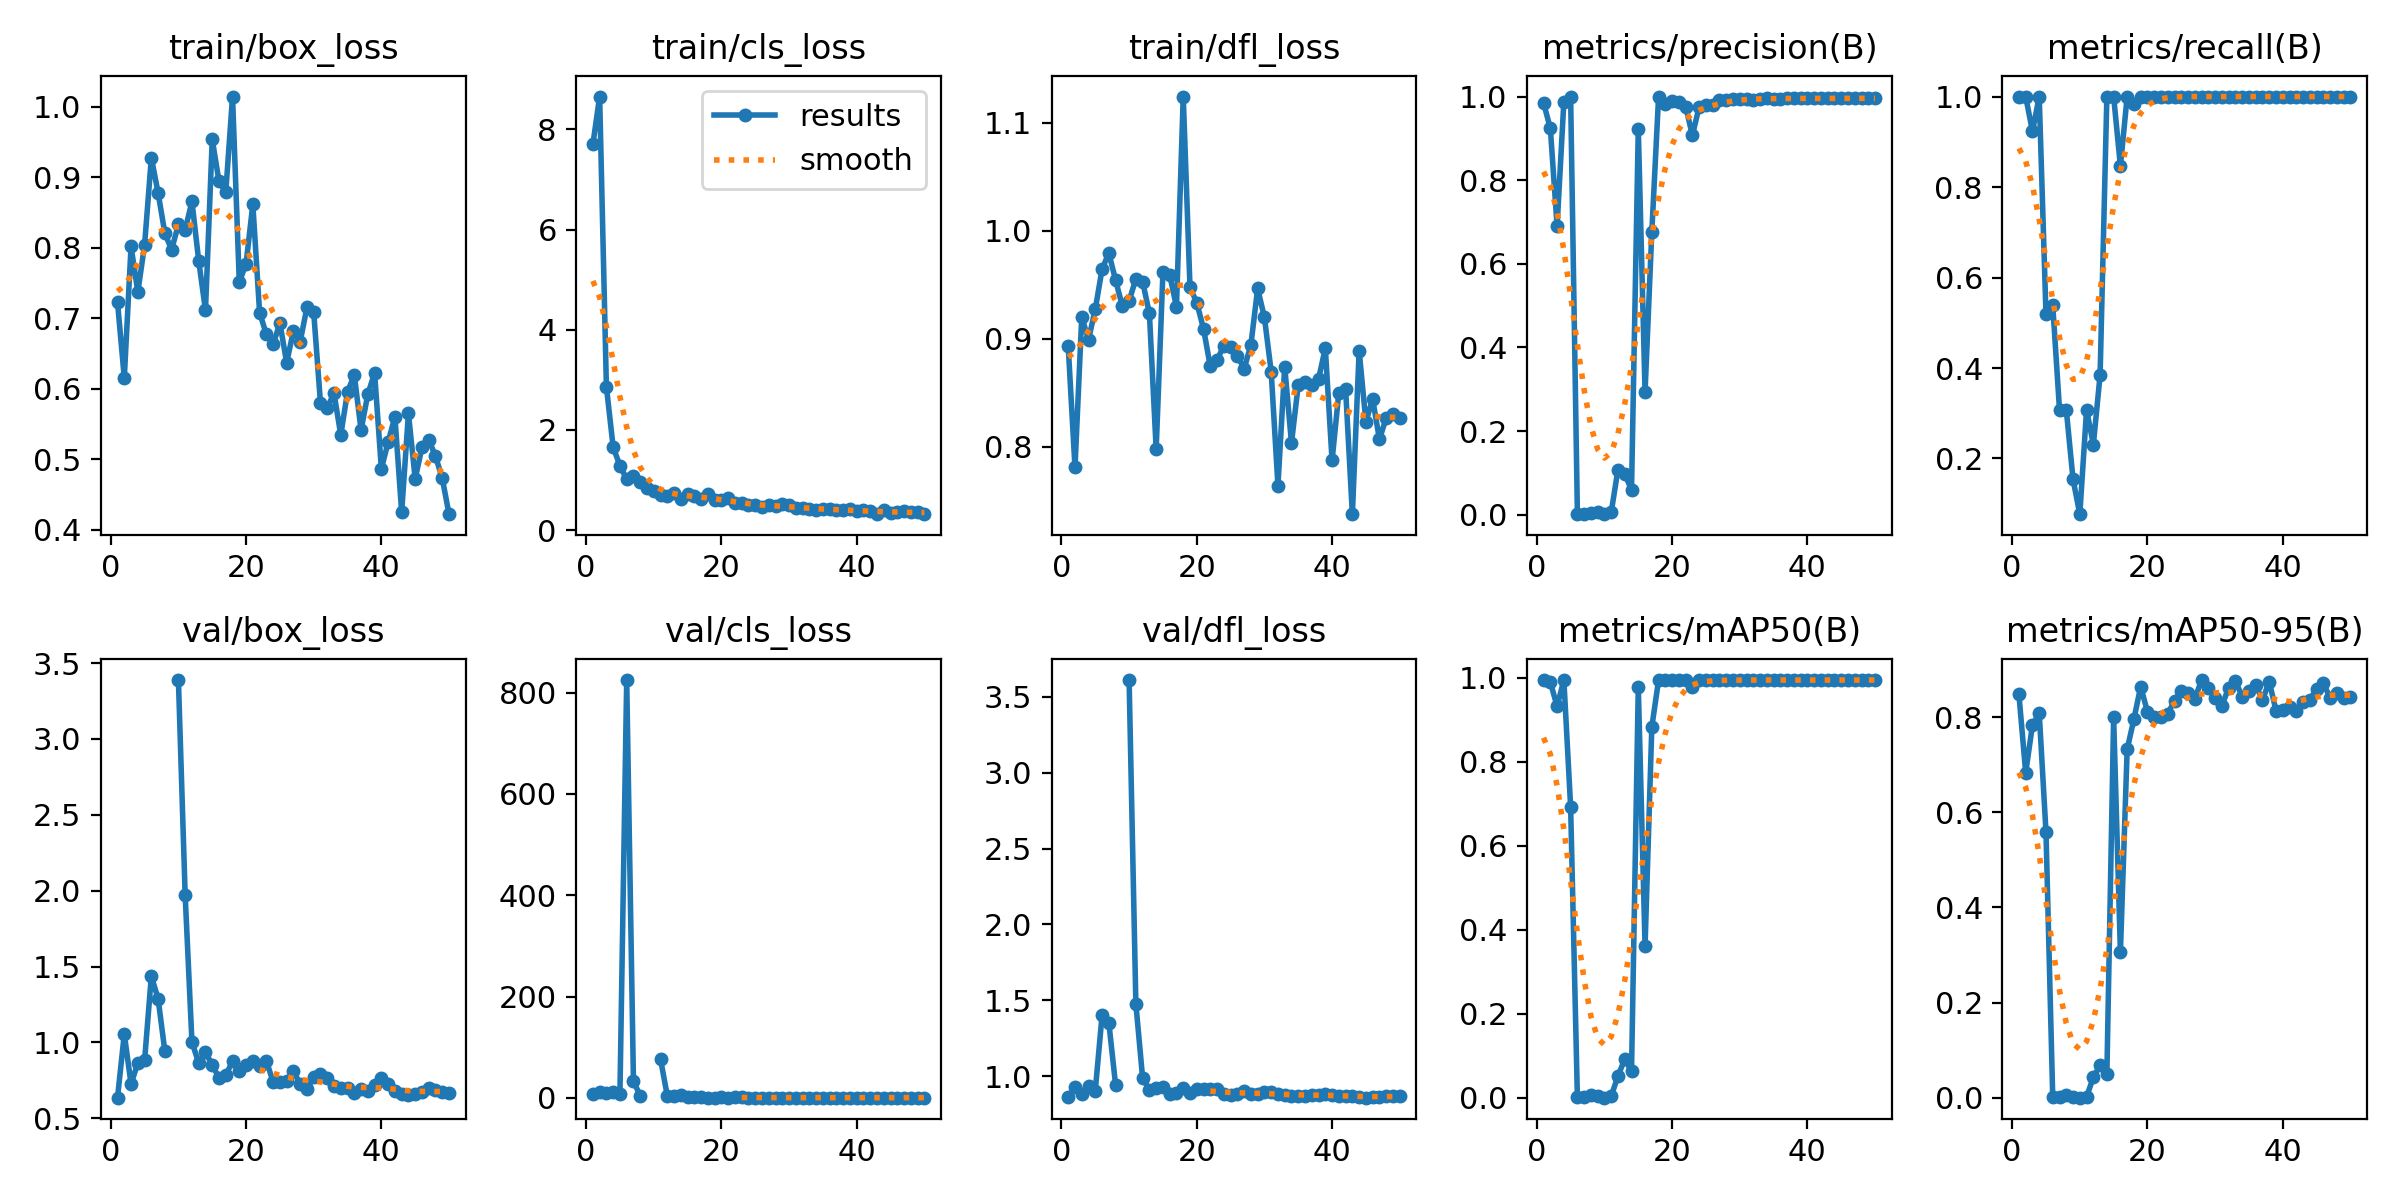

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=1200)

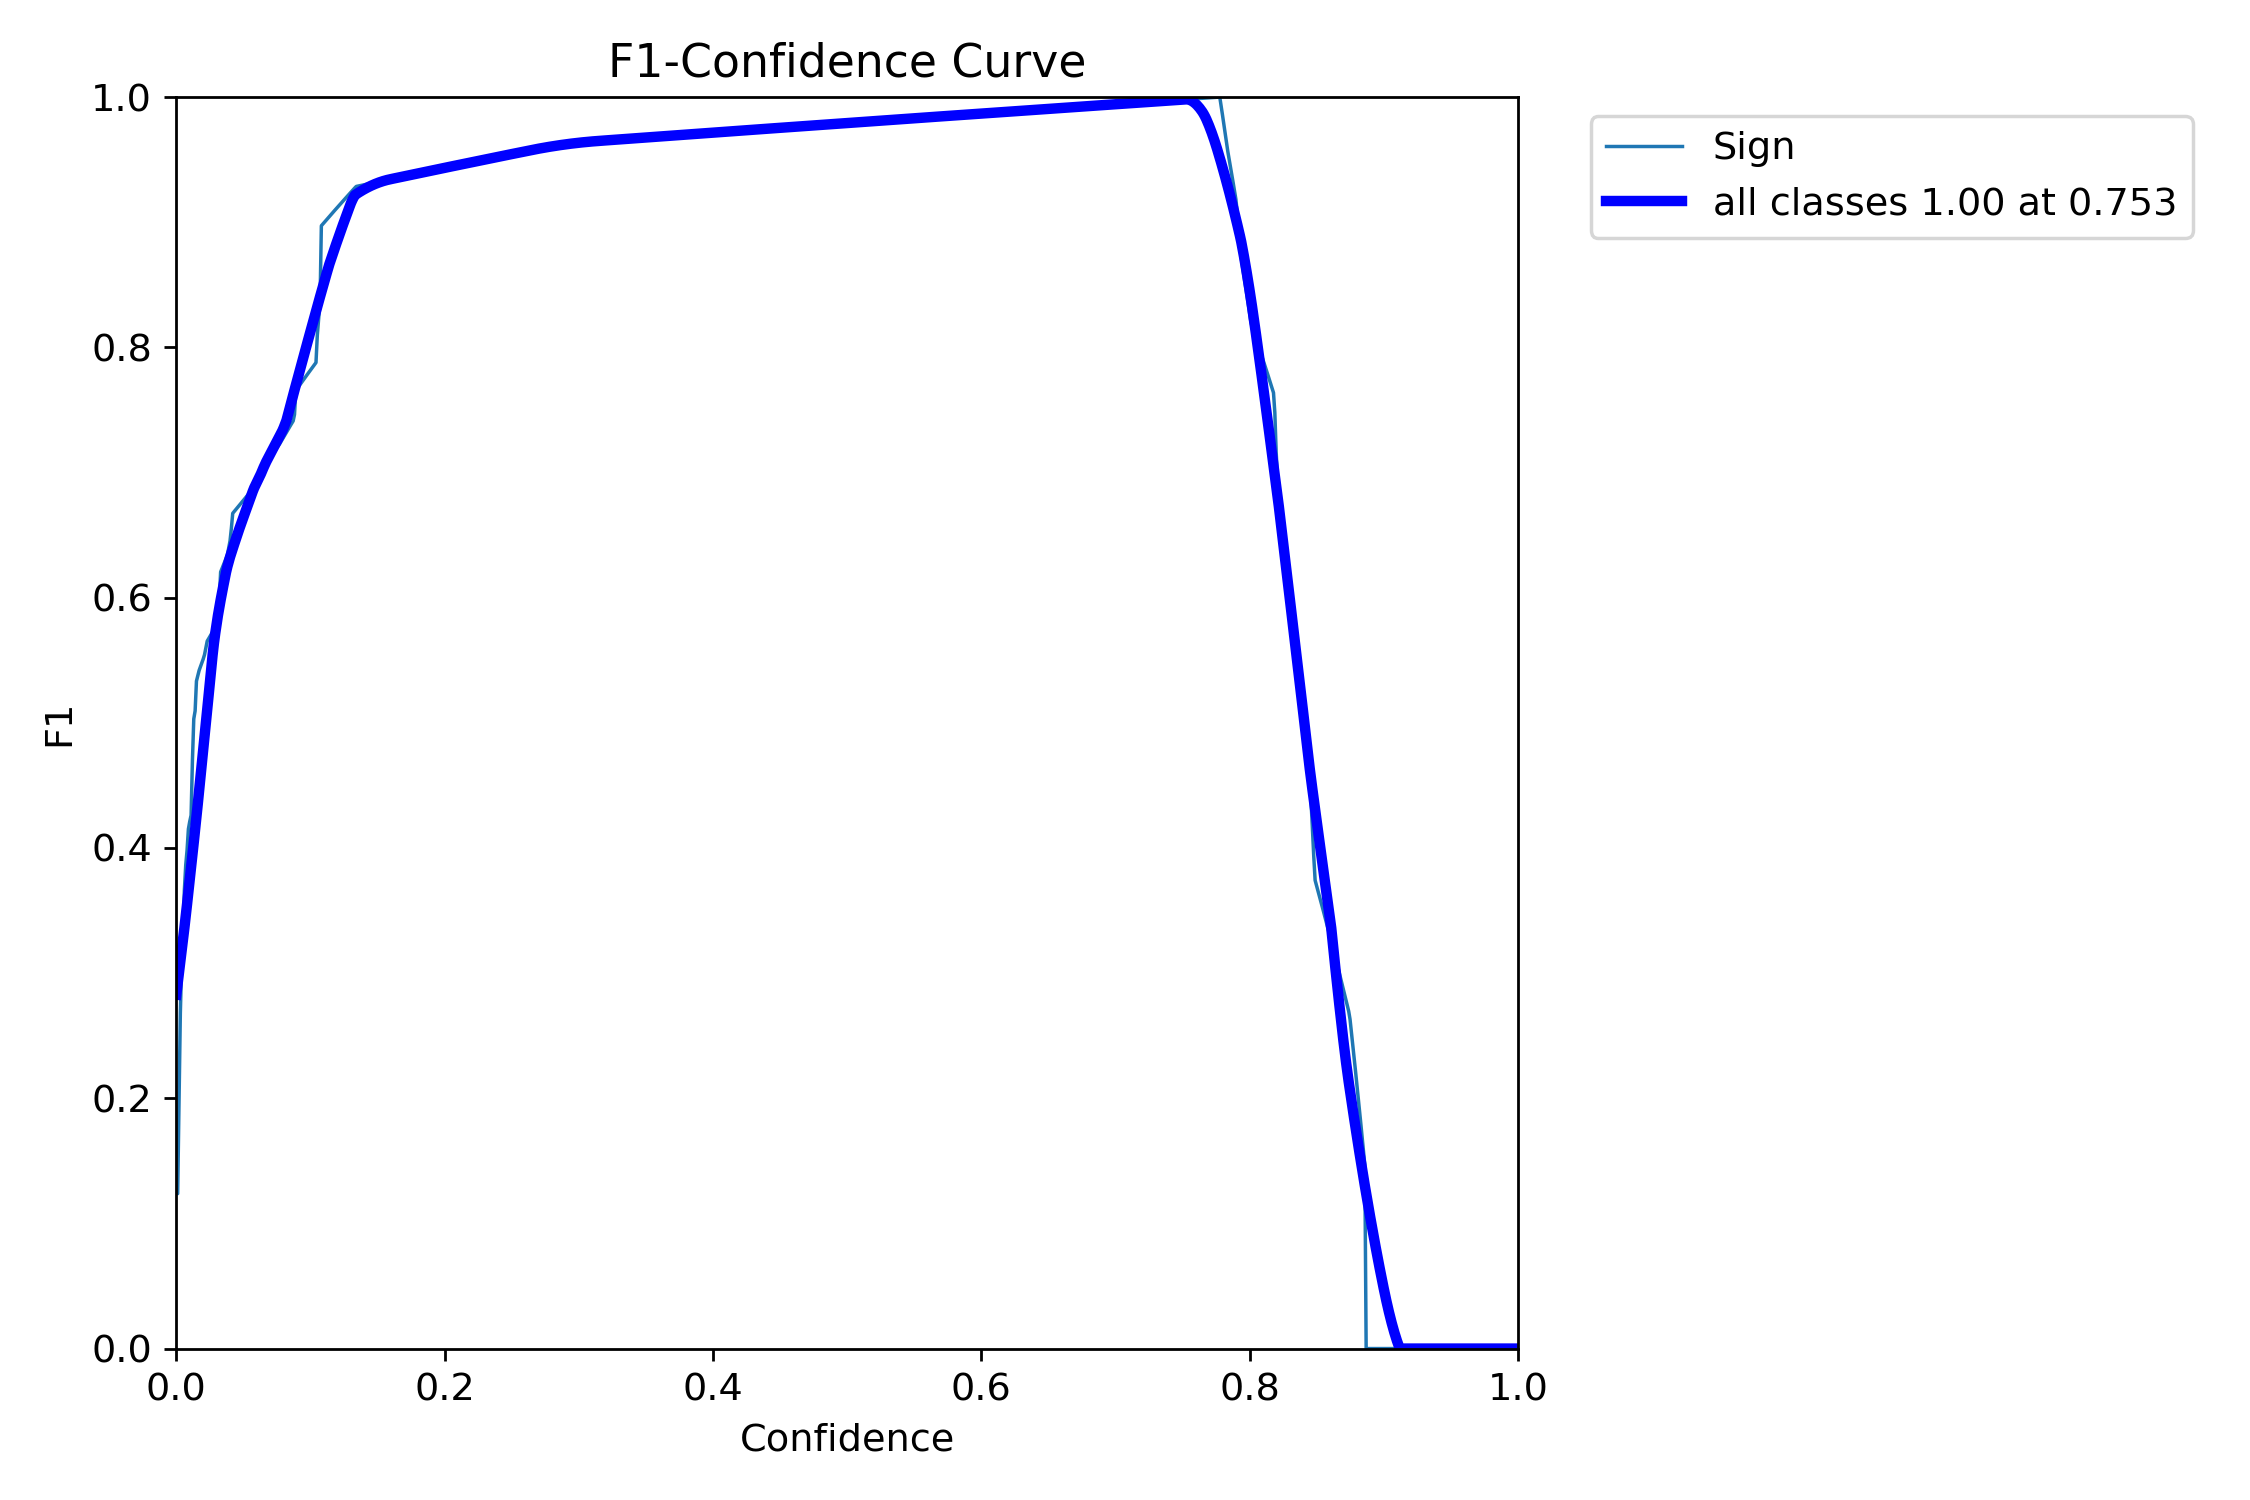

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/train/F1_curve.png', width=1200)

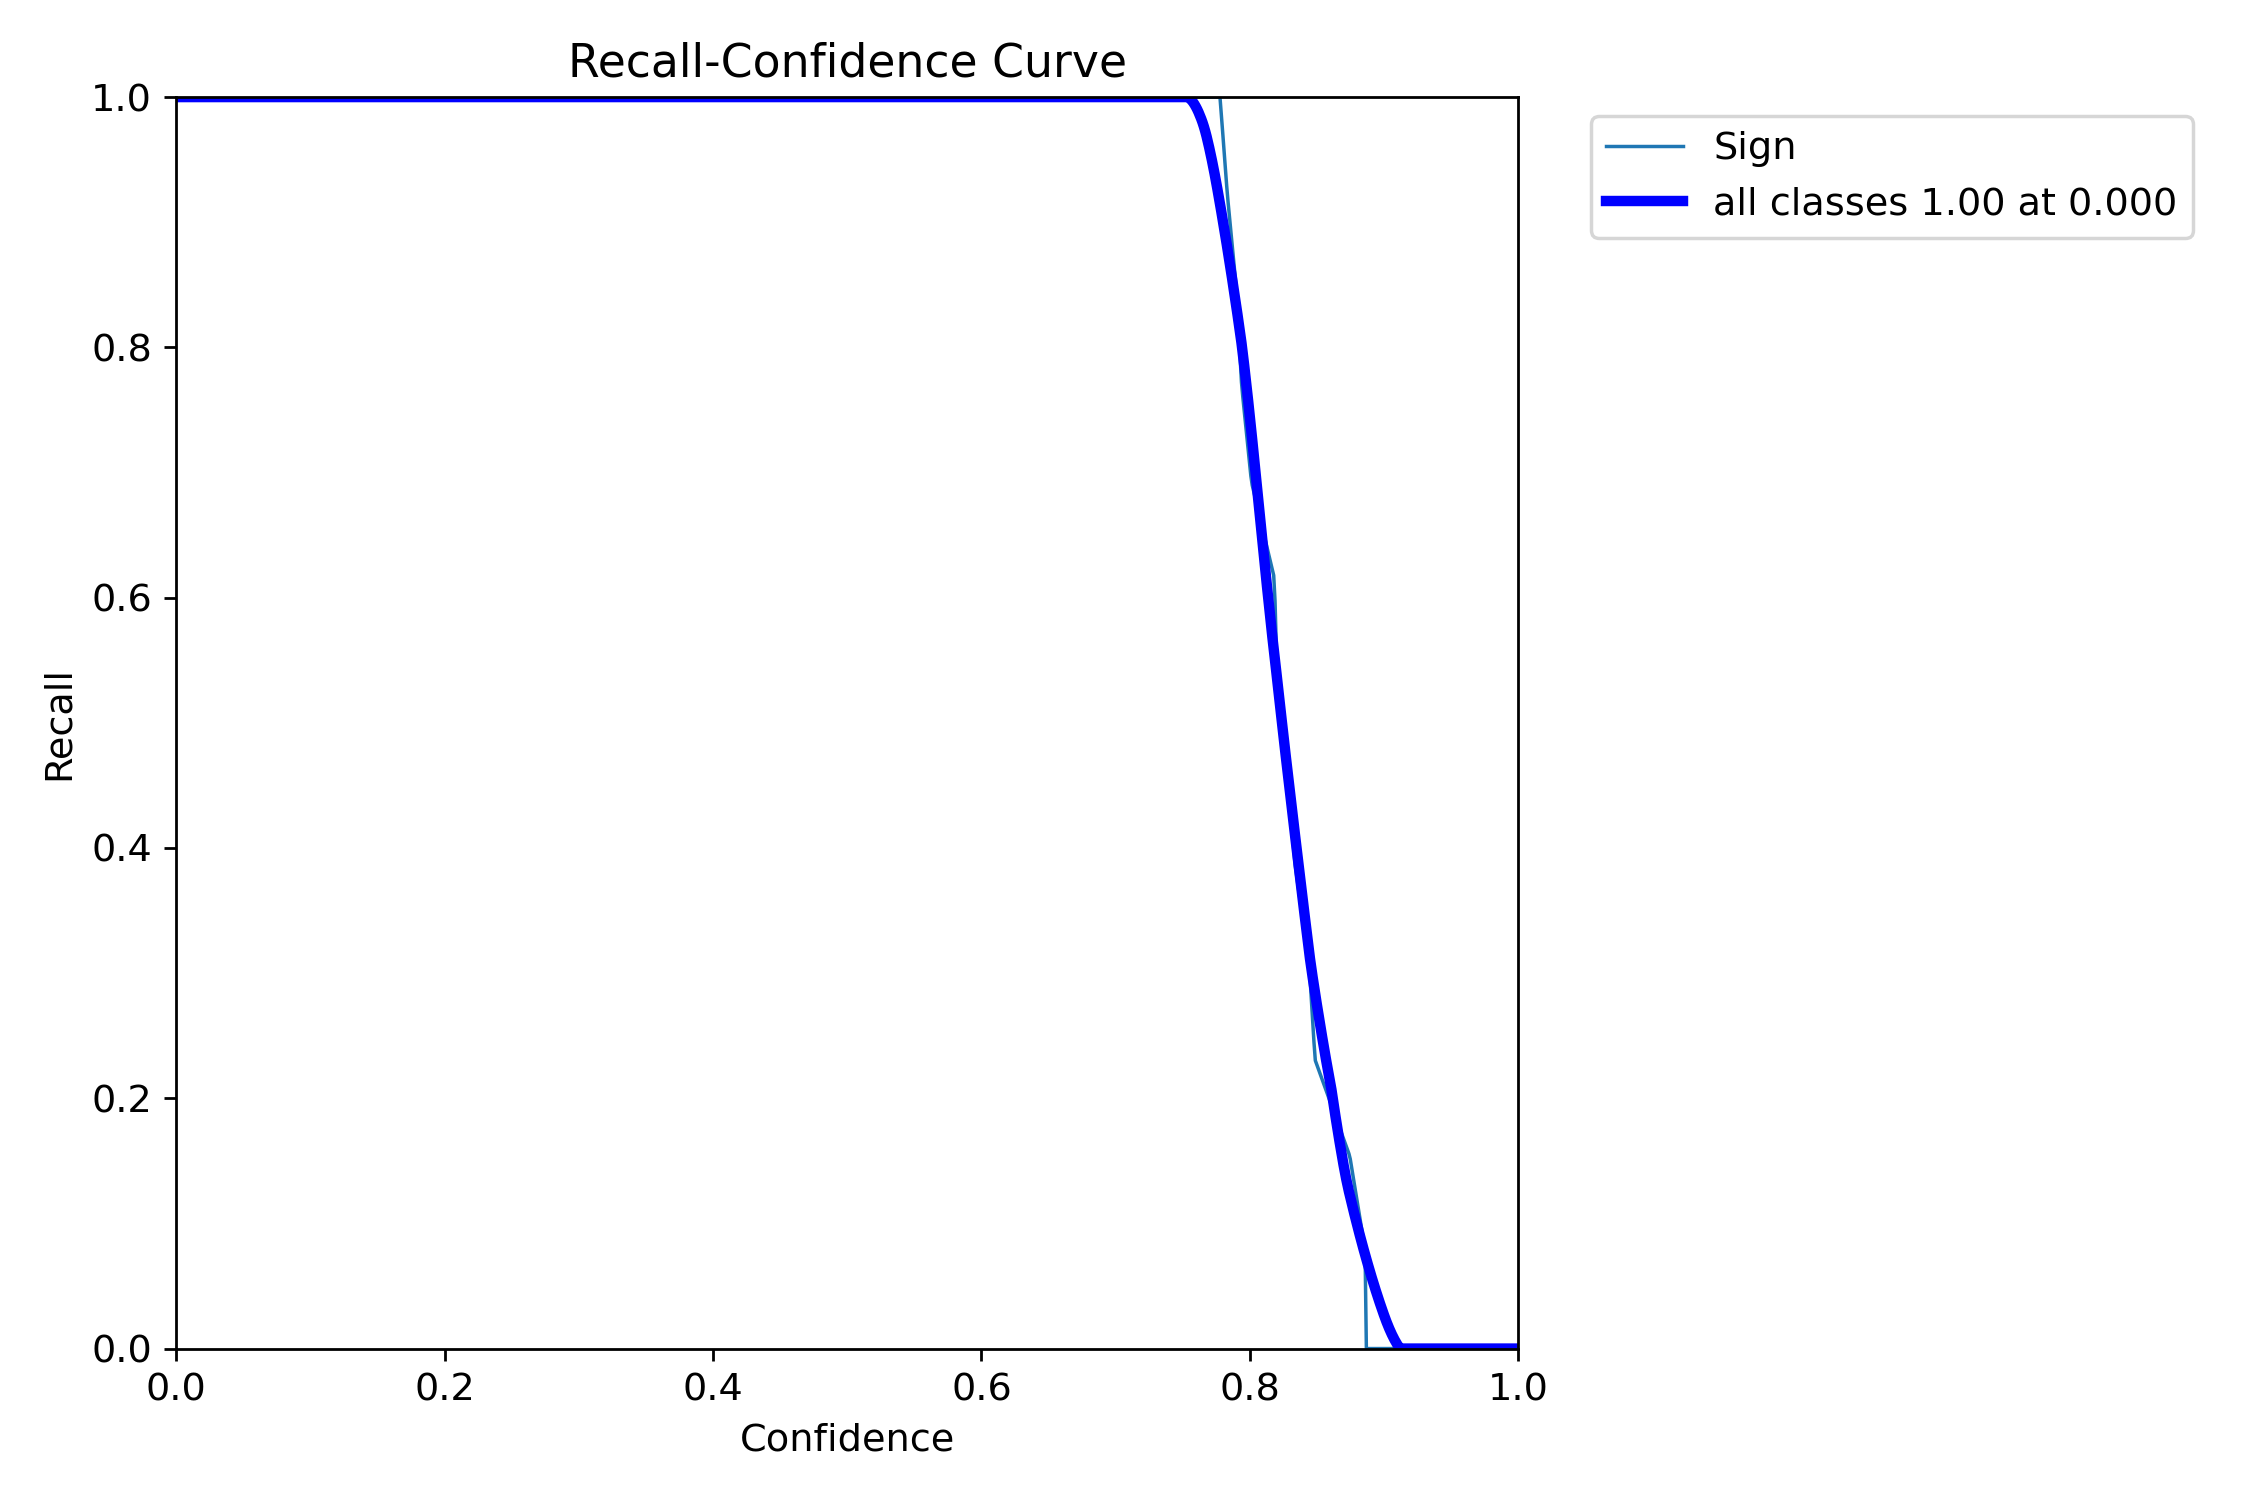

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/train/R_curve.png', width=1200)

View a training batch to see the model output - provides quick visual feedback

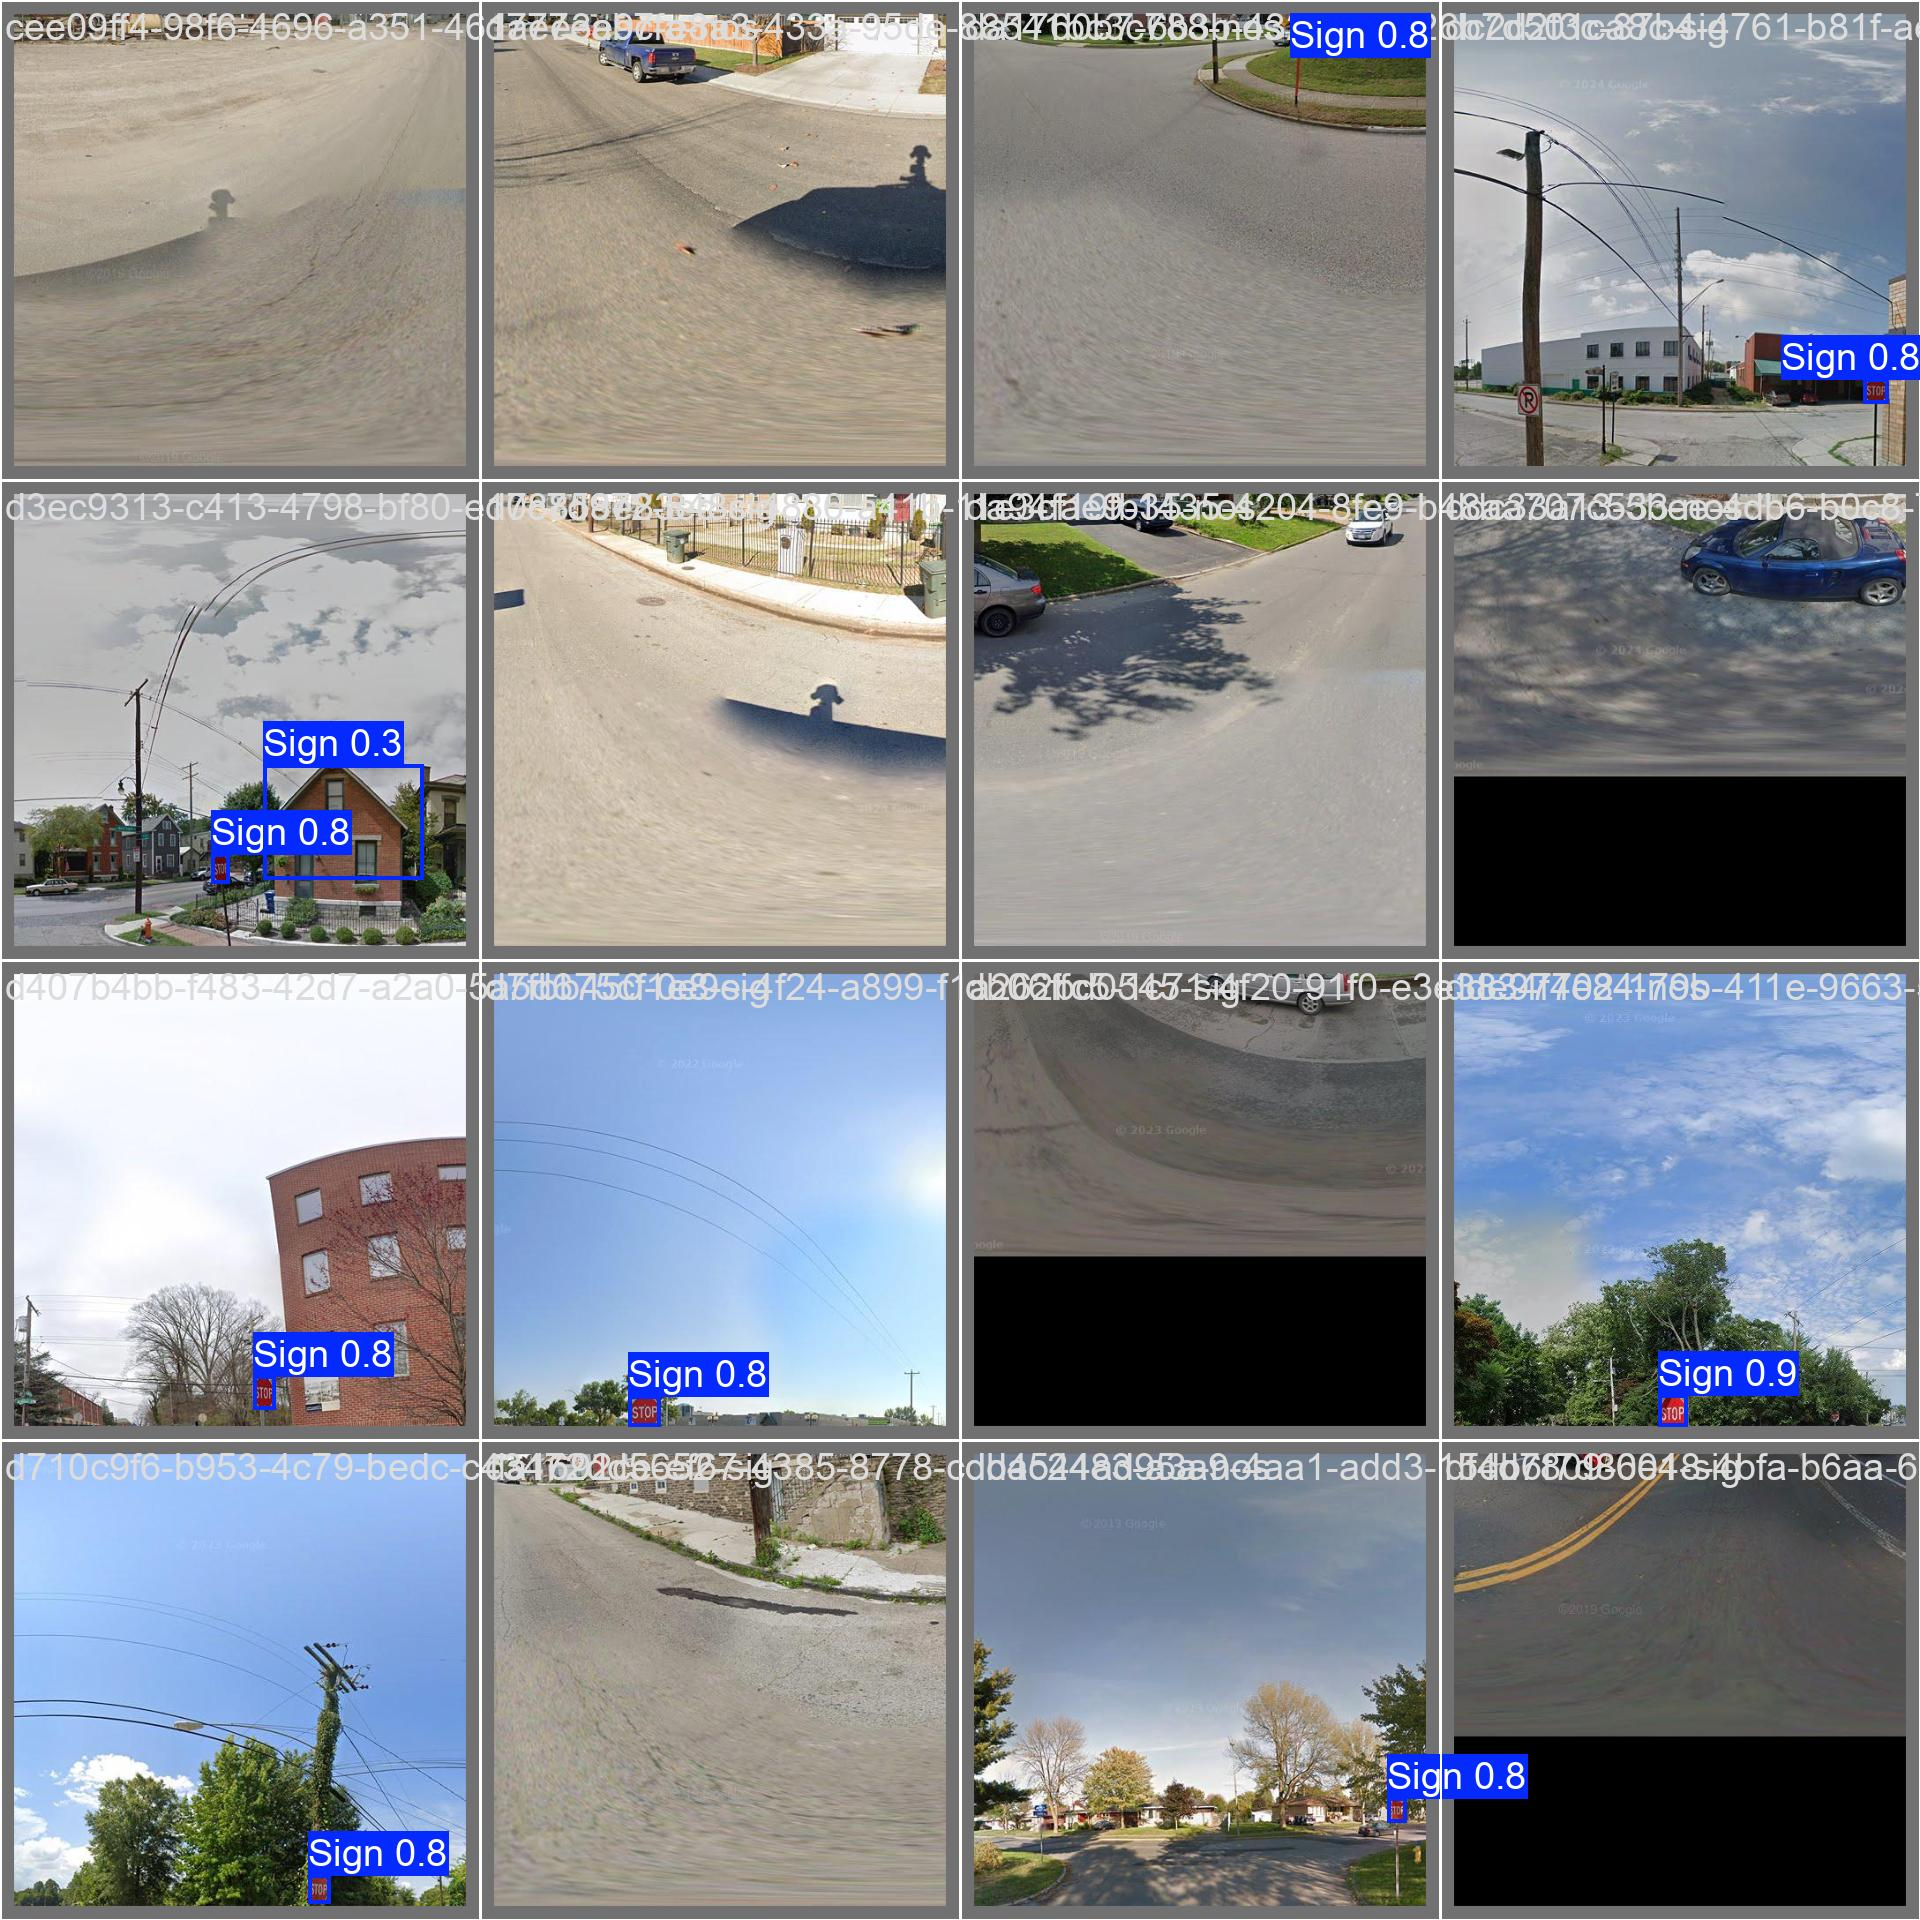

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=1600)

## YOLO Model Validation

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/StopSignFinder_withAI-1/valid/labels.cache... 24 images, 11 backgrounds, 0 corrupt: 100% 24/24 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:03<00:00,  1.80s/it]
                   all         24         13      0.993          1      0.995      0.885
Speed: 7.5ms preprocess, 17.4ms inference, 0.0ms loss, 98.9ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

Inference on the training data - iterate across images in the train/images folder

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/train/images save=True

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/114 /content/datasets/StopSignFinder_withAI-1/train/images/1a8a016d-508f-427f-a069-f2c882af3cd4-nosign_png.rf.525e8191f128dc2bb3747f8a4256b0eb.jpg: 512x512 3 Signs, 13.1ms
image 2/114 /content/datasets/StopSignFinder_withAI-1/train/images/1a9ebf63-12d3-470c-8d85-f8f0a2e9951f-nosign__png.rf.03fd9ff37c040f2659f4342c3e621bf1.jpg: 512x512 1 Sign, 11.2ms
image 3/114 /content/datasets/StopSignFinder_withAI-1/train/images/1a9ebf63-12d3-470c-8d85-f8f0a2e9951f-nosign_png.rf.7ad188850c143303e5143a718eb0e311.jpg: 512x512 1 Sign, 11.1ms
image 4/114 /content/datasets/StopSignFinder_withAI-1/train/images/23bf32b3-b41f-4798-aee1-589262da5fef-nosign__png.rf.8d874d2d78a258bf80f1a0980374a049.jpg: 512x512 1 Sign, 11.1ms
image 5/114 /content/datasets/StopSignFinder_withAI-1/train/images/23bf32b3-b41f-4798-aee1-589262da5fef-nosign_png

Predicition on the test data

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/100 /content/datasets/StopSignFinder_withAI-1/test/images/e0762af3-aeee-4e8a-8c03-7b10873541d4-nosign_png.rf.02c29b71b3113a2b55cce4599e8a3bc7.jpg: 512x512 (no detections), 13.2ms
image 2/100 /content/datasets/StopSignFinder_withAI-1/test/images/e1623e7b-e36d-466a-a122-e1a558b7f5b9-sign_png.rf.17690c484ae33dcab11a012f3a765c2b.jpg: 512x512 1 Sign, 11.1ms
image 3/100 /content/datasets/StopSignFinder_withAI-1/test/images/e1629188-79ac-4808-924f-ecb6359617cd-sign_png.rf.bcdb9f647ebe0bc11183e515c3607e59.jpg: 512x512 1 Sign, 11.1ms
image 4/100 /content/datasets/StopSignFinder_withAI-1/test/images/e5760387-fc63-4b2d-9d7e-d70e632ac375-sign_png.rf.00bfc4e1ff11c6707398123d0cfad6eb.jpg: 512x512 1 Sign, 11.1ms
image 5/100 /content/datasets/StopSignFinder_withAI-1/test/images/e592c7e7-4c4e-4cb1-9ea1-1158e2e2e3fc-nosign_png.rf.a

# Automated way to compare the image file name (-sign or -nosign) and see if the detections match. Calculate statistics in the process

Get a result for a single image

In [ ]:
result = !yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images/e0762af3-aeee-4e8a-8c03-7b10873541d4-nosign_png.rf.02c29b71b3113a2b55cce4599e8a3bc7.jpg

In [ ]:
result

['Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)',
 'YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs',
 '',
 'image 1/1 /content/datasets/StopSignFinder_withAI-1/test/images/e0762af3-aeee-4e8a-8c03-7b10873541d4-nosign_png.rf.02c29b71b3113a2b55cce4599e8a3bc7.jpg: 512x512 (no detections), 12.3ms',
 'Speed: 1.7ms preprocess, 12.3ms inference, 52.1ms postprocess per image at shape (1, 3, 512, 512)',
 'Results saved to \x1bruns/detect/predict3\x1b',
 '💡 Learn more at https://docs.ultralytics.com/modes/predict']

# Inference on the model for stats

Loop through the test set to compile statistics

In [ ]:
from ultralytics import YOLO
import glob
import os
import cv2
import matplotlib.pyplot as plt

# Load the model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# List of images to process
img_files_folder = glob.glob(os.path.join('/content/datasets/StopSignFinder_withAI-1/test/images/', '*.jpg'))
print(img_files_folder)

#sign or no sign string
no_sign_string = "-nosign"
sign_string = "-sign"

#stats calculator
counter = 0
false_detections = 0
missed_detections = 0

# Process each image and print the results
for image_path in img_files_folder:
    print(f"Results for {image_path}:")

    counter = counter + 1
    sign_in_image = False #known truth
    sign_detected = False # predicition

    #determine if file name has sign or no sign indicator
    if no_sign_string in image_path:
      sign_in_image = False

    if sign_string in image_path:
      sign_in_image = True

    results = model.predict(source=image_path, conf=0.25, save=False)  # Save=False do not save annotated images
    detections = results[0].boxes if len(results) > 0 else None
    if detections and len(detections) > 0:
        sign_detected = True
        # Draw on the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for box in detections.xywh.cpu().numpy():
            x_center, y_center, width, height = box
            # Convert xywh to x1, y1, x2, y2 for plotting
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw the rectangle on the image
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)

        # Display the image
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()

    if(sign_in_image == True and sign_detected == False):
      missed_detections = missed_detections + 1
      print("Missed Detection")

    if(sign_in_image == False and sign_detected == True):
      false_detections = false_detections + 1
      print("False Positive")

    if(sign_in_image == sign_detected):
      print("Inference Passed")


# output final statistics
false_detection_rate = float(false_detections)/float(counter)
missed_detection_rate = float(missed_detections)/float(counter)
print()
print(f"{counter} images evaluated. {missed_detections} missed detections were found at a rate of {missed_detection_rate} and {false_detections} false positive were found at a rate of {false_detection_rate}")


Output hidden; open in https://colab.research.google.com to view.

## Deploy model on Roboflow

Optional area to upload data back to Roboflow

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

View the status of your deployment at: https://app.roboflow.com/screws-nvbc9/stopsignfinder_withai/1
Share your model with the world at: https://universe.roboflow.com/screws-nvbc9/stopsignfinder_withai/model/1


# Download to Local PC (model files)

Download data to PC by zipping files for datasets and runs (runs contains the best.pt file found in runs/detect/train/weights/)

In [ ]:
!zip -r datasets.zip datasets/

  adding: datasets/ (stored 0%)
  adding: datasets/StopSignFinder_withAI-1/ (stored 0%)
  adding: datasets/StopSignFinder_withAI-1/test/ (stored 0%)
  adding: datasets/StopSignFinder_withAI-1/test/labels/ (stored 0%)
  adding: datasets/StopSignFinder_withAI-1/test/labels/f1f6afb8-48cd-42ce-8dcd-a644ac92ace8-sign_png.rf.80afb3e04206a552d48342c0e3c2a619.txt (deflated 20%)
  adding: datasets/StopSignFinder_withAI-1/test/labels/eeca3cd0-5b6e-44f8-beeb-06754c106ea4-nosign_png.rf.d7e354649cfc780cafe59a0792926504.txt (stored 0%)
  adding: datasets/StopSignFinder_withAI-1/test/labels/f239e3ac-4228-4d22-a0cb-70e4a7e0fd20-sign_png.rf.585c55b19ecb73c56621e2941d8f639c.txt (deflated 20%)
  adding: datasets/StopSignFinder_withAI-1/test/labels/f15b3b71-dca1-49ca-9588-accc715e4cb0-sign_png.rf.df96736473091408fd93944c1e7b91d3.txt (deflated 18%)
  adding: datasets/StopSignFinder_withAI-1/test/labels/ece72f15-4adf-400e-a6e8-6df451bf92f5-sign_png.rf.210e515e2dafcb160b1f16dc44f36929.txt (deflated 21%)
  ad

In [ ]:
!zip -r runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/predict5/ (stored 0%)
  adding: runs/detect/predict5/e0762af3-aeee-4e8a-8c03-7b10873541d4-nosign_png.rf.02c29b71b3113a2b55cce4599e8a3bc7.jpg (deflated 9%)
  adding: runs/detect/val/ (stored 0%)
  adding: runs/detect/val/PR_curve.png (deflated 30%)
  adding: runs/detect/val/P_curve.png (deflated 19%)
  adding: runs/detect/val/F1_curve.png (deflated 16%)
  adding: runs/detect/val/val_batch0_labels.jpg (deflated 10%)
  adding: runs/detect/val/val_batch1_pred.jpg (deflated 10%)
  adding: runs/detect/val/confusion_matrix.png (deflated 43%)
  adding: runs/detect/val/val_batch0_pred.jpg (deflated 10%)
  adding: runs/detect/val/R_curve.png (deflated 20%)
  adding: runs/detect/val/val_batch1_labels.jpg (deflated 10%)
  adding: runs/detect/val/confusion_matrix_normalized.png (deflated 40%)
  adding: runs/detect/predict/ (stored 0%)
  adding: runs/detect/predict/de7813b5-46e4-453b-8bb1-7ab3e1dc8e7e-nosign__png.rf